In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [5]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

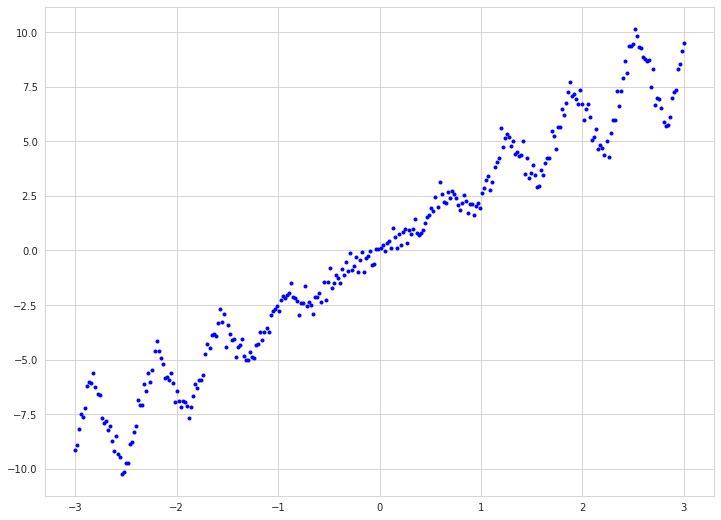

In [6]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [7]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, ax, depth, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    ax.set_title(str(depth) + ' depth')
    ax.plot(x1, y_pred, linewidth=2)

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

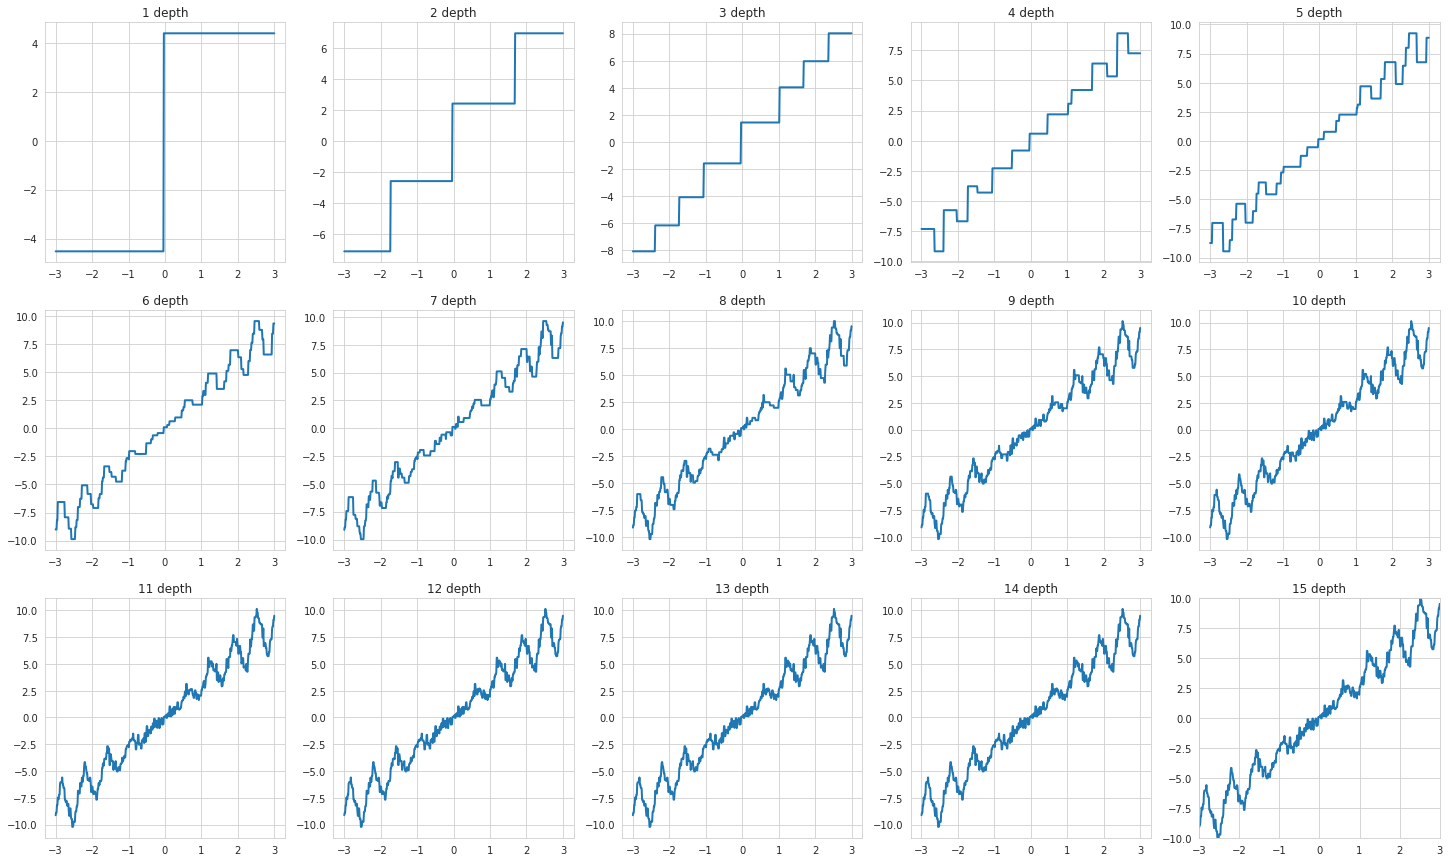

In [8]:
# for d in range(1,16):

fig, axes = plt.subplots(3, 5, figsize = (25,15))

for ax, depth in zip(axes.ravel(), range(1,16)):
    dt_regressor = DecisionTreeRegressor(max_depth=depth)
    dt_regressor.fit(X,y)
    plot_regression_predictions(dt_regressor, ax=ax, depth=depth)

**I'd prefer depth of 6 since it has optimal variance and bias**

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [9]:
from math import comb

In [10]:
def binomial_sum(p, n_success, n_classifiers=101):
     s = map( lambda x: comb(n_classifiers, x) * (p ** x) * ((1 - p) ** (n_classifiers - x)),
             [_ for _ in range(n_success, n_classifiers+1)])
     return sum(s)


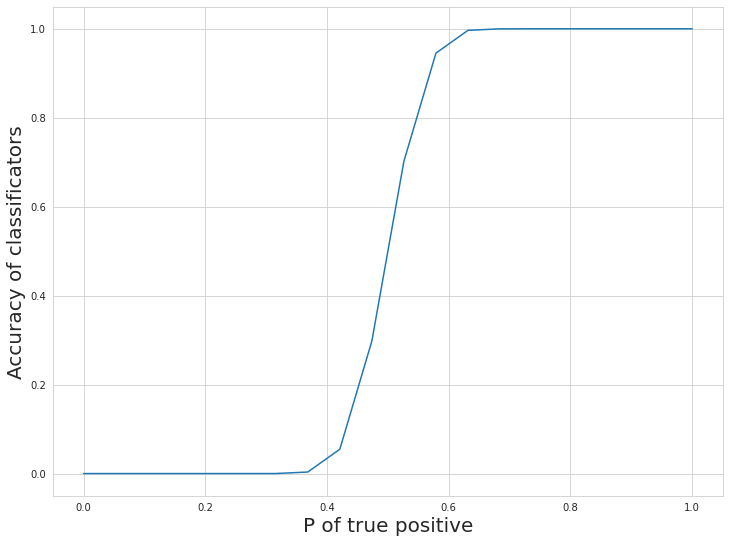

In [11]:
pp = list(map(lambda x: binomial_sum(x, 51, 101), np.linspace(0,1,20)))
plt.xlabel('P of true positive', fontsize=20)
plt.ylabel('Accuracy of classificators', fontsize=20)
plt.plot(np.linspace(0,1,20), pp);


А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [12]:
def binomial_assembles(p, n_classifiers):

    n_success = n_classifiers // 2 + n_classifiers % 2

    s = map( lambda x: comb(n_classifiers, x) * (p ** x) * ((1 - p) ** (n_classifiers - x)),
             [_ for _ in range(n_success, n_classifiers+1)])
    return sum(s)


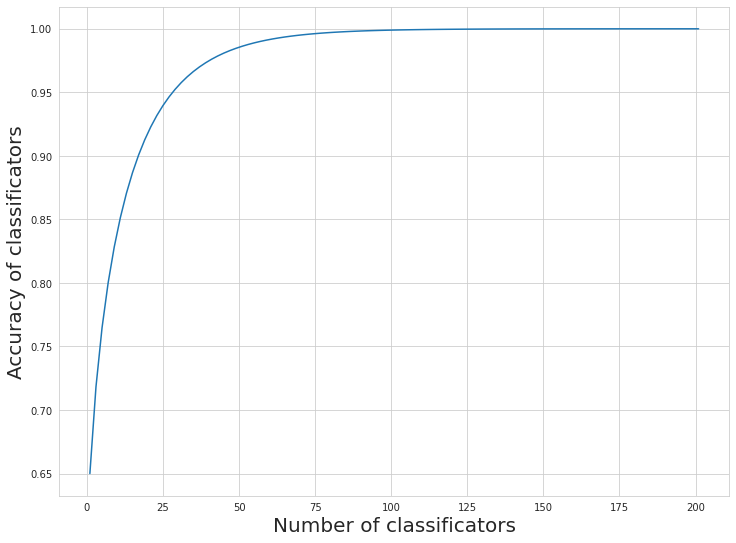

In [13]:
ppp = list(map(lambda x: binomial_assembles(0.65, x), np.linspace(1,201,101).astype('int64')))
plt.xlabel('Number of classificators', fontsize=20)
plt.ylabel('Accuracy of classificators', fontsize=20)
plt.plot(np.linspace(1,201,101), ppp);

Опишите ваши наблюдения:

* **Вероятность верной оценки увеличивается с ростом вероятности верной классификации моделей в ансамблях**
* **и с ростом количества модели в ансамблях - тоже**

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [14]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        for i in range(self.n_estimators+1):
            np.random.seed(self.random_state + i)

            feats_rsm = np.random.choice(X.shape[1], 
                                         self.max_features,
                                         replace=False)
            
            self.feat_ids_by_tree.append(feats_rsm)

            boot_idx = np.random.choice(X.shape[0], size=X.shape[0],
                                        replace=True)

            
            X_boot = X[boot_idx][:,feats_rsm]
            y_boot = y[boot_idx]

            dtc = DecisionTreeClassifier(max_depth=self.max_depth, 
                                   max_features=self.max_features,
                                   random_state=self.random_state)
            dtc.fit(X_boot, y_boot)
            self.trees.append(dtc)
            
        return self
        
    def predict_proba(self, X):
        probs = []
        for i in range(self.n_estimators+1):
            probs.append(self.trees[i].predict_proba(X[:,self.feat_ids_by_tree[i]]))
        return(np.mean(probs, axis=0))
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [15]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

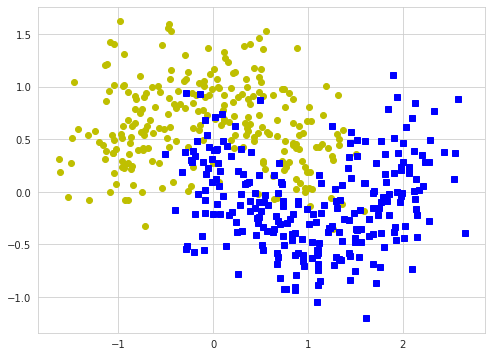

In [16]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

In [18]:
scores_df = []
for depth in [1, 2, 3, 4, 5, 8, 10, 15]:
    for n_ests in [5, 8, 10, 15, 20, 30]:
        cur_row = [depth]
        cur_row.append(n_ests)
        rfc = RandomForestClassifierCustom(n_estimators=n_ests, max_depth=depth, max_features=2, random_state=SEED)
        cur_row.append(cross_val_score(rfc, X_train, y_train, cv=5, scoring='roc_auc').mean())
        cur_row.append(cross_val_score(rfc, X_train, y_train, cv=5, scoring='accuracy').mean())
        scores_df.append(cur_row)
    

In [19]:
pd.DataFrame(scores_df, columns = ['Depth', 'Number of estimators', 'ROC AUC', "Accuracy"]).\
    sort_values(by=['ROC AUC', "Accuracy"], ascending=False).head(10)

,Depth,Number of estimators,ROC AUC,Accuracy
28,5,20,0.957370,0.893333
27,5,15,0.956730,0.896000
25,5,8,0.956649,0.882667
29,5,30,0.956518,0.898667
26,5,10,0.956014,0.885333
24,5,5,0.955220,0.877333
34,8,20,0.951181,0.898667
35,8,30,0.951038,0.904000
31,8,8,0.949818,0.896000
33,8,15,0.949398,0.888000


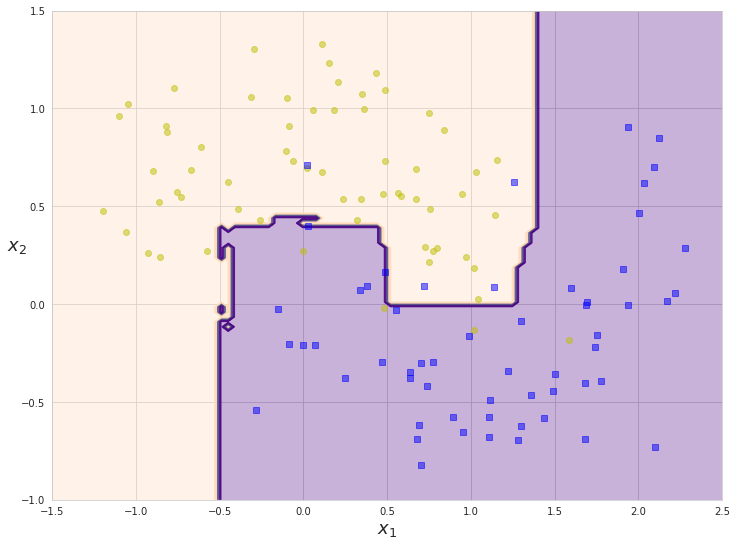

In [20]:
rfc = RandomForestClassifierCustom(n_estimators=20, max_depth=5, max_features=2, random_state=SEED)
rfc.fit(X_train, y_train)
plot_decision_boundary(rfc, X_test, y_test)

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [21]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [22]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [23]:
rt = RandomForestClassifier()
rt.fit(X_train, y_train)
cs = base_model_pair_correlation(rt, X_test)

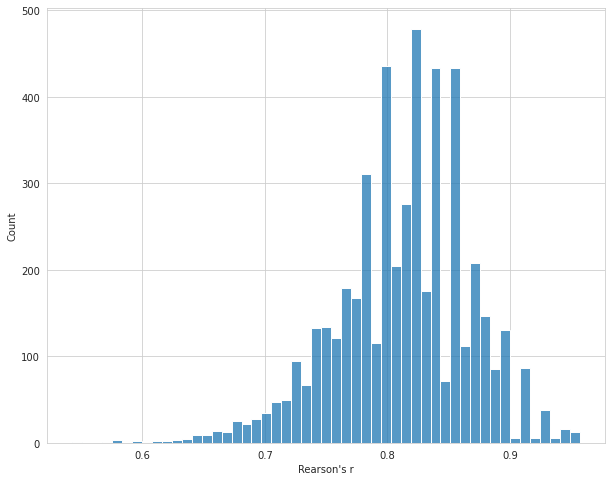

In [24]:
plt.rcParams["figure.figsize"] = 10, 8
sns.histplot(cs);
plt.xlabel("Rearson's r");

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

---


In [25]:
c = []
for max_feats in [1,2,3,5,8,10,15,20,30]:
    rt = RandomForestClassifier(max_features = max_feats)
    rt.fit(X_train, y_train)
    c.append(base_model_pair_correlation(rt, X_test))

In [26]:
c_df = pd.DataFrame(c, index = [1,2,3,5,8,10,15,20,30]).transpose()
c_df.head()

,1,2,3,5,8,10,15,20,30
0,0.706310,0.823892,0.747721,0.797334,0.822727,0.787601,0.771737,0.824969,0.870015
1,0.760260,0.840894,0.731539,0.752851,0.896336,0.857955,0.854534,0.897692,0.767000
2,0.778906,0.852860,0.676180,0.783874,0.720350,0.829152,0.869206,0.869206,0.796178
3,0.728792,0.765189,0.801625,0.725989,0.824283,0.818694,0.854835,0.897692,0.752061
4,0.729052,0.827496,0.779163,0.809908,0.810679,0.733180,0.812060,0.854141,0.693084


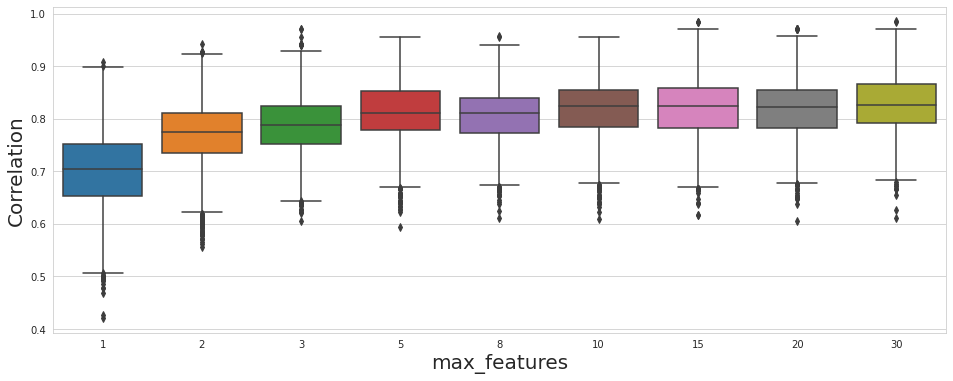

In [27]:
plt.figure(figsize=(16,6));

sns.boxplot(data=c_df);
plt.xlabel("max_features", size=20);
plt.ylabel("Correlation", size=20);

Опишите ваши наблюдения:

* Корреляция увеличивается с увеличением признаков, но выходит на плато
* Слишком мало/много признаков -> плохая модель/переобучение  
Можно найти оптимум

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [31]:
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [102]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [33]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [34]:
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')

list_of_models = [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]

for model in list_of_models: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.820158269808819
LGBMClassifier: 0.8129461544095692
XGBRFClassifier: 0.8426829268292683
LGBMClassifier: 0.8101597492003888
LogisticRegression: 0.8500073681108163
GaussianNB: 0.8140676625250128
VotingClassifier: 0.8395804737268152
VotingClassifier: 0.8503633581946834


Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [35]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))

    return corrs

In [36]:
voting_hard.fit(X_train, y_train);
voting_soft.fit(X_train, y_train);

In [39]:
corrs = base_model_pair_correlation_for_voting_clf(voting_hard, X_train)
for i in corrs:
    if i[2] > 0.95:
        print(i[0].__class__.__name__, i[1].__class__.__name__)

RandomForestClassifier ExtraTreesClassifier
RandomForestClassifier KNeighborsClassifier
RandomForestClassifier CatBoostClassifier
RandomForestClassifier LGBMClassifier
RandomForestClassifier XGBClassifier
RandomForestClassifier XGBRFClassifier
ExtraTreesClassifier KNeighborsClassifier
ExtraTreesClassifier CatBoostClassifier
ExtraTreesClassifier LGBMClassifier
ExtraTreesClassifier XGBClassifier
KNeighborsClassifier CatBoostClassifier
KNeighborsClassifier LGBMClassifier
KNeighborsClassifier XGBClassifier
SVC LogisticRegression
CatBoostClassifier LGBMClassifier
CatBoostClassifier XGBClassifier
CatBoostClassifier XGBRFClassifier
LGBMClassifier XGBClassifier
LGBMClassifier XGBRFClassifier


In [41]:
for m in [("RF", rf), ("KNN", knn), ("ETC", etc), ("LGBM", lgbm), ("XGB", xgb), ("CAT", cat)]:
    b = base_models.copy()
    b.remove(m)

    voting_hard = VotingClassifier(estimators=b, voting='hard')
    voting_soft = VotingClassifier(estimators=b, voting='soft')

    scores_hard = cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1")
    scores_soft = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
    print(f"Voting hard without {m[1].__class__.__name__}: {scores_hard.mean()}")
    print(f"Voting soft without {m[1].__class__.__name__}: {scores_soft.mean()}")
    print()

Voting hard without RandomForestClassifier: 0.8420582916461167
Voting soft without RandomForestClassifier: 0.853949856084979

Voting hard without KNeighborsClassifier: 0.8395804737268152
Voting soft without KNeighborsClassifier: 0.8551737994775969

Voting hard without ExtraTreesClassifier: 0.8347994448494008
Voting soft without ExtraTreesClassifier: 0.8550318922749822

Voting hard without LGBMClassifier: 0.8431938431938434
Voting soft without LGBMClassifier: 0.84856642687968

Voting hard without XGBClassifier: 0.8468393205235311
Voting soft without XGBClassifier: 0.8449328449328449

Voting hard without CatBoostClassifier: 0.8468393205235311
Voting soft without CatBoostClassifier: 0.853949856084979



In [42]:
for m1, m2 in combinations([("RF", rf), ("KNN", knn), 
                                      ("ETC", etc), ("LGBM", lgbm),
                                      ("XGB", xgb), ("CAT", cat)], 2):
    
    b = base_models.copy()

    b.remove(m1)
    b.remove(m2)

    voting_hard = VotingClassifier(estimators=b, voting='hard')
    voting_soft = VotingClassifier(estimators=b, voting='soft')

    scores_hard = cross_val_score(voting_hard, X_train, y_train, cv=5, scoring="f1")
    scores_soft = cross_val_score(voting_soft, X_train, y_train, cv=5, scoring="f1")
    print(f"Voting hard without {m1[1].__class__.__name__} and {m2[1].__class__.__name__}: {scores_hard.mean()}")
    print(f"Voting soft without {m1[1].__class__.__name__} and {m2[1].__class__.__name__}: {scores_soft.mean()}")
    print()

Voting hard without RandomForestClassifier and KNeighborsClassifier: 0.8352755594991621
Voting soft without RandomForestClassifier and KNeighborsClassifier: 0.842233045767484

Voting hard without RandomForestClassifier and ExtraTreesClassifier: 0.8418159888068703
Voting soft without RandomForestClassifier and ExtraTreesClassifier: 0.855745645776041

Voting hard without RandomForestClassifier and LGBMClassifier: 0.8449838794598937
Voting soft without RandomForestClassifier and LGBMClassifier: 0.8433238770685578

Voting hard without RandomForestClassifier and XGBClassifier: 0.8467139479905438
Voting soft without RandomForestClassifier and XGBClassifier: 0.8524515281289821

Voting hard without RandomForestClassifier and CatBoostClassifier: 0.8419035872134855
Voting soft without RandomForestClassifier and CatBoostClassifier: 0.8490622915832999

Voting hard without KNeighborsClassifier and ExtraTreesClassifier: 0.8446618357487923
Voting soft without KNeighborsClassifier and ExtraTreesClassi

In [43]:
b = base_models.copy()

b.remove(("LGBM", lgbm))
b.remove(("CAT", cat))


for m1, m2 in combinations([("RF", rf), ("KNN", knn), 
                            ("ETC", etc),
                            ("XGB", xgb)], 2):
    b_new = b.copy()
    
    b_new.remove(m1)
    b_new.remove(m2)

    voting_hard = VotingClassifier(estimators=b_new, voting='hard')
    voting_soft = VotingClassifier(estimators=b_new, voting='soft')

    scores_hard = cross_val_score(voting_hard, X_train, y_train, cv=5, scoring="f1")
    scores_soft = cross_val_score(voting_soft, X_train, y_train, cv=5, scoring="f1")
    print(f"Voting hard without {m1[1].__class__.__name__} and {m2[1].__class__.__name__}: {scores_hard.mean()}")
    print(f"Voting soft without {m1[1].__class__.__name__} and {m2[1].__class__.__name__}: {scores_soft.mean()}")
    print()

Voting hard without RandomForestClassifier and KNeighborsClassifier: 0.8483381771538141
Voting soft without RandomForestClassifier and KNeighborsClassifier: 0.8416828001093792

Voting hard without RandomForestClassifier and ExtraTreesClassifier: 0.8514519282890461
Voting soft without RandomForestClassifier and ExtraTreesClassifier: 0.8606083908740801

Voting hard without RandomForestClassifier and XGBClassifier: 0.8501962969049522
Voting soft without RandomForestClassifier and XGBClassifier: 0.8546781747624783

Voting hard without KNeighborsClassifier and ExtraTreesClassifier: 0.8480161334427126
Voting soft without KNeighborsClassifier and ExtraTreesClassifier: 0.8529481062318283

Voting hard without KNeighborsClassifier and XGBClassifier: 0.8514994425863991
Voting soft without KNeighborsClassifier and XGBClassifier: 0.8502770993831248

Voting hard without ExtraTreesClassifier and XGBClassifier: 0.8530115080958115
Voting soft without ExtraTreesClassifier and XGBClassifier: 0.8574672904

In [44]:
for m in [("RF", rf), ("KNN", knn), ("ETC", etc), ("XGB", xgb)]:
    b_new = b.copy()
    b_new.remove(m)

    voting_hard = VotingClassifier(estimators=b_new, voting='hard')
    voting_soft = VotingClassifier(estimators=b_new, voting='soft')

    scores_hard = cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1")
    scores_soft = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
    print(f"Voting hard without {m[1].__class__.__name__}: {scores_hard.mean()}")
    print(f"Voting soft without {m[1].__class__.__name__}: {scores_soft.mean()}")
    print()

Voting hard without RandomForestClassifier: 0.851356032357316
Voting soft without RandomForestClassifier: 0.8459606874549758

Voting hard without KNeighborsClassifier: 0.8481888481888481
Voting soft without KNeighborsClassifier: 0.8547619047619047

Voting hard without ExtraTreesClassifier: 0.8477105550276282
Voting soft without ExtraTreesClassifier: 0.8499095840867993

Voting hard without XGBClassifier: 0.8486772486772486
Voting soft without XGBClassifier: 0.8500429864957745



In [45]:
base_models_new = [("DT", dt), ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

In [46]:
for m in base_models_new:
    b = base_models_new.copy()
    b.remove(m)

    voting_hard = VotingClassifier(estimators=b, voting='hard')
    voting_soft = VotingClassifier(estimators=b, voting='soft')

    scores_hard = cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1")
    scores_soft = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
    print(f"Voting hard without {m[1].__class__.__name__}: {scores_hard.mean()}")
    print(f"Voting soft without {m[1].__class__.__name__}: {scores_soft.mean()}")
    print()

Voting hard without DecisionTreeClassifier: 0.8600823045267489
Voting soft without DecisionTreeClassifier: 0.8455110375195781

Voting hard without LGBMClassifier: 0.8551737994775969
Voting soft without LGBMClassifier: 0.8575741091949798

Voting hard without XGBClassifier: 0.8672243068584531
Voting soft without XGBClassifier: 0.8529203232683821

Voting hard without XGBRFClassifier: 0.8779571212763898
Voting soft without XGBRFClassifier: 0.8575741091949798

Voting hard without LogisticRegression: 0.8523324065492739
Voting soft without LogisticRegression: 0.8536144578313252

Voting hard without GaussianNB: 0.8539156626506023
Voting soft without GaussianNB: 0.8492063492063492



In [47]:
from sklearn.metrics import f1_score

###  методом проб и ошибок для **voting hard** получил:

In [136]:
base_models_new = [
                ('RF', rf),
                ("LGBM", lgbm), 
                ("LR", lr), 
                ("NB", nb)
                ]

In [137]:
voting_hard = VotingClassifier(estimators=base_models_new, voting='hard')
voting_soft = VotingClassifier(estimators=base_models_new, voting='soft')

voting_hard.fit(X_train, y_train)
voting_soft.fit(X_train, y_train)

y_pred_hard = voting_hard.predict(X_test)
y_pred_soft = voting_soft.predict(X_test)

print(
f1_score(y_test, y_pred_hard)
# f1_score(y_test, y_pred_soft)
)

0.8979591836734694


#### УРА, больше 0.89

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV

In [51]:
data = pd.read_csv("churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [52]:
print(data.shape)
data.describe()

(3333, 21)


,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [53]:
data['Area Code'].value_counts()

415    1655
510     840
408     838
Name: Area Code, dtype: int64

In [54]:
data['Area Code'] = data['Area Code'].astype('object')

In [55]:
data['Phone'].nunique()

3333

In [56]:
data = data.drop('Phone', axis=1)

In [57]:
data.iloc[:,-1].value_counts()

False.    2850
True.      483
Name: Churn?, dtype: int64

### OHE

In [58]:
X, y = data.iloc[:,:-1], data.iloc[:,-1]

In [59]:
y = LabelEncoder().fit_transform(y)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=SEED)

In [61]:
one_hot_encoder = make_column_transformer(
    (OneHotEncoder(sparse=False,
    handle_unknown='ignore'),
     make_column_selector(dtype_include='object')),
    remainder='passthrough')

### MODELLING XGBClassifier

**После многих проб и ошибок:**

In [62]:
xgb = xgboost.XGBClassifier(learning_rate=0.5, #speed 
                             max_depth=8, #depth of tree
                             n_estimators=100, #number of classificators in ensemble 
                             subsample=1, #bagging
                             min_split_loss = 0, #min loss reduction to split the node
                             eval_metric='error', #function of loss (error for clasification)
                             scale_pos_weight=5, #since imbalanced classes
                             objective="binary:logistic",
                           ) 

In [63]:
pipeline = Pipeline(steps=
                   [('OHE', one_hot_encoder),
                   ('XGB', xgb)])

In [64]:
pipeline.fit(X_train, y_train);

In [65]:
y_pred = pipeline.predict(X_test)

In [66]:
from sklearn.metrics import accuracy_score

In [67]:
cross_val_score(estimator=pipeline, X=X_train, y=y_train, cv=3, scoring="f1").mean()

0.8146680804575541

In [68]:
print(f'F1 = {f1_score(y_test, y_pred)}\nACC = {accuracy_score(y_test, y_pred)}')

F1 = 0.8505747126436781
ACC = 0.9610194902548725


* Логистическая регресси я показала себя лучше всех.  
* Наилучшая глубина - 8,  
* Скорость обучения - 0.5 (довольно высокая кстати)  
* Наилучшая еличина ансамбля оказалась дефолтной
* colsample node, level, tree - не показали улучшения модели (а наоборот), поэтому subsample=1,  
* min_split_loss = 0, модель лучше себя чувтсвует & когда свободнее  
* Метрики  logloss и error показвают себя одинаково**

### При этом обычная модель:

In [69]:
xgb_default = xgboost.XGBClassifier(random_state=SEED)

In [70]:
pipeline_default = Pipeline(steps=
                   [('OHE', one_hot_encoder),
                   ('XGB', xgb_default)])

In [71]:
pipeline_default.fit(X_train, y_train);

In [72]:
y_pr = pipeline_default.predict(X_test)

In [73]:
cross_val_score(estimator=pipeline_default, X=X_train, y=y_train, cv=3, scoring="f1").mean()

0.8112839723886904

In [74]:
print(f'F1 = {f1_score(y_test, y_pr)}\nACC = {accuracy_score(y_test, y_pr)}')

F1 = 0.8117647058823529
ACC = 0.952023988005997


### MODELLING xgboost.XGBRFClassifier

In [75]:
xgbrf = xgboost.XGBRFClassifier(
                                random_state=SEED,
                                max_depth=20,
                                learning_rate=1, # no effect
                                n_estimators=800,
                                objective='binary:logistic',
                                scale_pos_weight=6,
                                eval_metric='error',
                                colsample_bynode=0.2,
                               )

In [76]:
pipeline_rf = Pipeline(steps=
                   [('OHE', one_hot_encoder),
                   ('RF', xgbrf)])

In [77]:
pipeline_rf.fit(X_train, y_train);

In [78]:
y_pred_rf = pipeline_rf.predict(X_test)

In [79]:
cross_val_score(estimator=pipeline_rf, X=X_train, y=y_train, cv=3, scoring="f1").mean()

0.8120006189433105

In [80]:
print(f'F1 = {f1_score(y_test, y_pred_rf)}\nACC = {accuracy_score(y_test, y_pred_rf)}')

F1 = 0.8268156424581007
ACC = 0.9535232383808095


* В данном случае увелчение размера ансамбля хорошо повлияло на предсказания (1000)
* Логистическая регрессия
* learning rate сильно не влияет
* max depth лучше в районе 20-30

### Default model

In [81]:
xgbrf_def = xgboost.XGBRFClassifier(
                                random_state=SEED
                               )

In [82]:
pipeline_default = Pipeline(steps=
                   [('OHE', one_hot_encoder),
                   ('XGB', xgbrf_def)])

In [83]:
pipeline_default.fit(X_train, y_train);

In [84]:
y_pr = pipeline_default.predict(X_test)

In [85]:
cross_val_score(estimator=pipeline_default, X=X_train, y=y_train, cv=3, scoring="f1").mean()

0.796941651173626

In [86]:
print(f'F1 = {f1_score(y_test, y_pr)}\nACC = {accuracy_score(y_test, y_pr)}')

F1 = 0.7710843373493975
ACC = 0.9430284857571214
